Copyright 2021 DeepMind Technologies Limited

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

     https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

This colab showcases the usage of the Enformer model published in

**"Effective gene expression prediction from sequence by integrating long-range interactions"**

Žiga Avsec, Vikram Agarwal, Daniel Visentin, Joseph R. Ledsam, Agnieszka Grabska-Barwinska, Kyle R. Taylor, Yannis Assael, John Jumper, Pushmeet Kohli, David R. Kelley

**Note:** This colab will not yet work since the model isn't yet publicly available. We are working on enabling this and will update the colab accordingly.

### Steps

This colab demonstrates how to
- Make predictions with Enformer and reproduce Fig. 1d
- Compute contribution scores and reproduce parts of Fig. 2a
- Predict the effect of a genetic variant and reproduce parts of Fig. 3g
- Score multiple variants in a VCF

## Setup

**Start the colab kernel with GPU**: Runtime -> Change runtime type -> GPU

In [2]:
import tensorflow as tf
# Make sure the GPU is enabled
assert tf.config.list_physical_devices('GPU'), 'Start the colab kernel with GPU: Runtime -> Change runtime type -> GPU'

In [3]:
!pip install kipoiseq==0.5.2 --quiet > /dev/null
# You can ignore the pyYAML error

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
referencing 0.36.2 requires attrs>=22.2.0, but you have attrs 21.4.0 which is incompatible.
jsonschema 4.23.0 requires attrs>=22.2.0, but you have attrs 21.4.0 which is incompatible.


### Imports

In [4]:
import tensorflow_hub as hub
import joblib
import gzip
import kipoiseq
from kipoiseq import Interval
import pyfaidx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [5]:

model_path = 'https://tfhub.dev/deepmind/enformer/1'
fasta_file = '/root/data/genome.fa'
clinvar_vcf = '/root/data/clinvar.vcf.gz'

In [6]:
# Download targets from Basenji2 dataset
# Cite: Kelley et al Cross-species regulatory sequence activity prediction. PLoS Comput. Biol. 16, e1008050 (2020).
targets_txt = 'https://raw.githubusercontent.com/calico/basenji/master/manuscripts/cross2020/targets_human.txt'
df_targets = pd.read_csv(targets_txt, sep='\t')
df_targets.head(3)

,index,genome,identifier,file,clip,scale,sum_stat,description
0,0,0,ENCFF833POA,/home/drk/tillage/datasets/human/dnase/encode/...,32,2,mean,DNASE:cerebellum male adult (27 years) and mal...
1,1,0,ENCFF110QGM,/home/drk/tillage/datasets/human/dnase/encode/...,32,2,mean,DNASE:frontal cortex male adult (27 years) and...
2,2,0,ENCFF880MKD,/home/drk/tillage/datasets/human/dnase/encode/...,32,2,mean,DNASE:chorion


### Download files

Download and index the reference genome fasta file

Credit to Genome Reference Consortium: https://www.ncbi.nlm.nih.gov/grc

Schneider et al 2017 http://dx.doi.org/10.1101/gr.213611.116: Evaluation of GRCh38 and de novo haploid genome assemblies demonstrates the enduring quality of the reference assembly

In [7]:
!mkdir -p /root/data
!wget -O - http://hgdownload.cse.ucsc.edu/goldenPath/hg38/bigZips/hg38.fa.gz | gunzip -c > {fasta_file}
pyfaidx.Faidx(fasta_file)
!ls /root/data

--2025-03-08 14:49:46--  http://hgdownload.cse.ucsc.edu/goldenPath/hg38/bigZips/hg38.fa.gz
Resolving hgdownload.cse.ucsc.edu (hgdownload.cse.ucsc.edu)... 128.114.119.163
Connecting to hgdownload.cse.ucsc.edu (hgdownload.cse.ucsc.edu)|128.114.119.163|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 983659424 (938M) [application/x-gzip]
Saving to: ‘STDOUT’

-                   100%[===================>] 938.09M  11.2MB/s    in 64s     

2025-03-08 14:50:51 (14.6 MB/s) - written to stdout [983659424/983659424]

genome.fa  genome.fa.fai


Download the clinvar file. Reference:

Landrum MJ, Lee JM, Benson M, Brown GR, Chao C, Chitipiralla S, Gu B, Hart J, Hoffman D, Jang W, Karapetyan K, Katz K, Liu C, Maddipatla Z, Malheiro A, McDaniel K, Ovetsky M, Riley G, Zhou G, Holmes JB, Kattman BL, Maglott DR. ClinVar: improving access to variant interpretations and supporting evidence. Nucleic Acids Res . 2018 Jan 4. PubMed PMID: 29165669 .


In [8]:
!wget https://ftp.ncbi.nlm.nih.gov/pub/clinvar/vcf_GRCh38/clinvar.vcf.gz -O /root/data/clinvar.vcf.gz

--2025-03-08 14:51:54--  https://ftp.ncbi.nlm.nih.gov/pub/clinvar/vcf_GRCh38/clinvar.vcf.gz
Resolving ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)... 130.14.250.10, 130.14.250.11, 130.14.250.12, ...
Connecting to ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)|130.14.250.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 149366868 (142M) [application/x-gzip]
Saving to: ‘/root/data/clinvar.vcf.gz’

/root/data/clinvar. 100%[===================>] 142.45M  11.8MB/s    in 14s     

2025-03-08 14:52:09 (10.5 MB/s) - ‘/root/data/clinvar.vcf.gz’ saved [149366868/149366868]



### Code (double click on the title to show the code)

In [9]:
# @title `Enformer`, `EnformerScoreVariantsNormalized`, `EnformerScoreVariantsPCANormalized`,
SEQUENCE_LENGTH = 393216

class Enformer:

  def __init__(self, tfhub_url):
    self._model = hub.load(tfhub_url).model

  def predict_on_batch(self, inputs):
    predictions = self._model.predict_on_batch(inputs)
    return {k: v.numpy() for k, v in predictions.items()}

  @tf.function
  def contribution_input_grad(self, input_sequence,
                              target_mask, output_head='human'):
    input_sequence = input_sequence[tf.newaxis]

    target_mask_mass = tf.reduce_sum(target_mask)
    with tf.GradientTape() as tape:
      tape.watch(input_sequence)
      prediction = tf.reduce_sum(
          target_mask[tf.newaxis] *
          self._model.predict_on_batch(input_sequence)[output_head]) / target_mask_mass

    input_grad = tape.gradient(prediction, input_sequence) * input_sequence
    input_grad = tf.squeeze(input_grad, axis=0)
    return tf.reduce_sum(input_grad, axis=-1)


class EnformerScoreVariantsRaw:

  def __init__(self, tfhub_url, organism='human'):
    self._model = Enformer(tfhub_url)
    self._organism = organism

  def predict_on_batch(self, inputs):
    ref_prediction = self._model.predict_on_batch(inputs['ref'])[self._organism]
    alt_prediction = self._model.predict_on_batch(inputs['alt'])[self._organism]

    return alt_prediction.mean(axis=1) - ref_prediction.mean(axis=1)


class EnformerScoreVariantsNormalized:

  def __init__(self, tfhub_url, transform_pkl_path,
               organism='human'):
    assert organism == 'human', 'Transforms only compatible with organism=human'
    self._model = EnformerScoreVariantsRaw(tfhub_url, organism)
    with tf.io.gfile.GFile(transform_pkl_path, 'rb') as f:
      transform_pipeline = joblib.load(f)
    self._transform = transform_pipeline.steps[0][1]  # StandardScaler.

  def predict_on_batch(self, inputs):
    scores = self._model.predict_on_batch(inputs)
    return self._transform.transform(scores)


class EnformerScoreVariantsPCANormalized:

  def __init__(self, tfhub_url, transform_pkl_path,
               organism='human', num_top_features=500):
    self._model = EnformerScoreVariantsRaw(tfhub_url, organism)
    with tf.io.gfile.GFile(transform_pkl_path, 'rb') as f:
      self._transform = joblib.load(f)
    self._num_top_features = num_top_features

  def predict_on_batch(self, inputs):
    scores = self._model.predict_on_batch(inputs)
    return self._transform.transform(scores)[:, :self._num_top_features]


# TODO(avsec): Add feature description: Either PCX, or full names.

In [10]:
# @title `variant_centered_sequences`

class FastaStringExtractor:

    def __init__(self, fasta_file):
        self.fasta = pyfaidx.Fasta(fasta_file)
        self._chromosome_sizes = {k: len(v) for k, v in self.fasta.items()}

    def extract(self, interval: Interval, **kwargs) -> str:
        # Truncate interval if it extends beyond the chromosome lengths.
        chromosome_length = self._chromosome_sizes[interval.chrom]
        trimmed_interval = Interval(interval.chrom,
                                    max(interval.start, 0),
                                    min(interval.end, chromosome_length),
                                    )
        # pyfaidx wants a 1-based interval
        sequence = str(self.fasta.get_seq(trimmed_interval.chrom,
                                          trimmed_interval.start + 1,
                                          trimmed_interval.stop).seq).upper()
        # Fill truncated values with N's.
        pad_upstream = 'N' * max(-interval.start, 0)
        pad_downstream = 'N' * max(interval.end - chromosome_length, 0)
        return pad_upstream + sequence + pad_downstream

    def close(self):
        return self.fasta.close()


def variant_generator(vcf_file, gzipped=False):
  """Yields a kipoiseq.dataclasses.Variant for each row in VCF file."""
  def _open(file):
    return gzip.open(vcf_file, 'rt') if gzipped else open(vcf_file)

  with _open(vcf_file) as f:
    for line in f:
      if line.startswith('#'):
        continue
      chrom, pos, id, ref, alt_list = line.split('\t')[:5]
      # Split ALT alleles and return individual variants as output.
      for alt in alt_list.split(','):
        yield kipoiseq.dataclasses.Variant(chrom=chrom, pos=pos,
                                           ref=ref, alt=alt, id=id)


def one_hot_encode(sequence):
  return kipoiseq.transforms.functional.one_hot_dna(sequence).astype(np.float32)


def variant_centered_sequences(vcf_file, sequence_length, gzipped=False,
                               chr_prefix=''):
  seq_extractor = kipoiseq.extractors.VariantSeqExtractor(
    reference_sequence=FastaStringExtractor(fasta_file))

  for variant in variant_generator(vcf_file, gzipped=gzipped):
    interval = Interval(chr_prefix + variant.chrom,
                        variant.pos, variant.pos)
    interval = interval.resize(sequence_length)
    center = interval.center() - interval.start

    reference = seq_extractor.extract(interval, [], anchor=center)
    alternate = seq_extractor.extract(interval, [variant], anchor=center)

    yield {'inputs': {'ref': one_hot_encode(reference),
                      'alt': one_hot_encode(alternate)},
           'metadata': {'chrom': chr_prefix + variant.chrom,
                        'pos': variant.pos,
                        'id': variant.id,
                        'ref': variant.ref,
                        'alt': variant.alt}}

In [11]:
# @title `plot_tracks`

def plot_tracks(tracks, interval, height=1.5):
  fig, axes = plt.subplots(len(tracks), 1, figsize=(20, height * len(tracks)), sharex=True)
  for ax, (title, y) in zip(axes, tracks.items()):
    ax.fill_between(np.linspace(interval.start, interval.end, num=len(y)), y)
    ax.set_title(title)
    sns.despine(top=True, right=True, bottom=True)
  ax.set_xlabel(str(interval))
  plt.tight_layout()

## Make predictions for a genetic sequenece

In [13]:
model = Enformer(model_path)

fasta_extractor = FastaStringExtractor(fasta_file)

In [23]:
# @title Make predictions for an genomic example interval
target_interval = kipoiseq.Interval('chr11', 35_082_742, 35_197_430)  # @param

sequence_one_hot = one_hot_encode(fasta_extractor.extract(target_interval.resize(SEQUENCE_LENGTH)))
predictions = model.predict_on_batch(sequence_one_hot[np.newaxis])['human'][0]

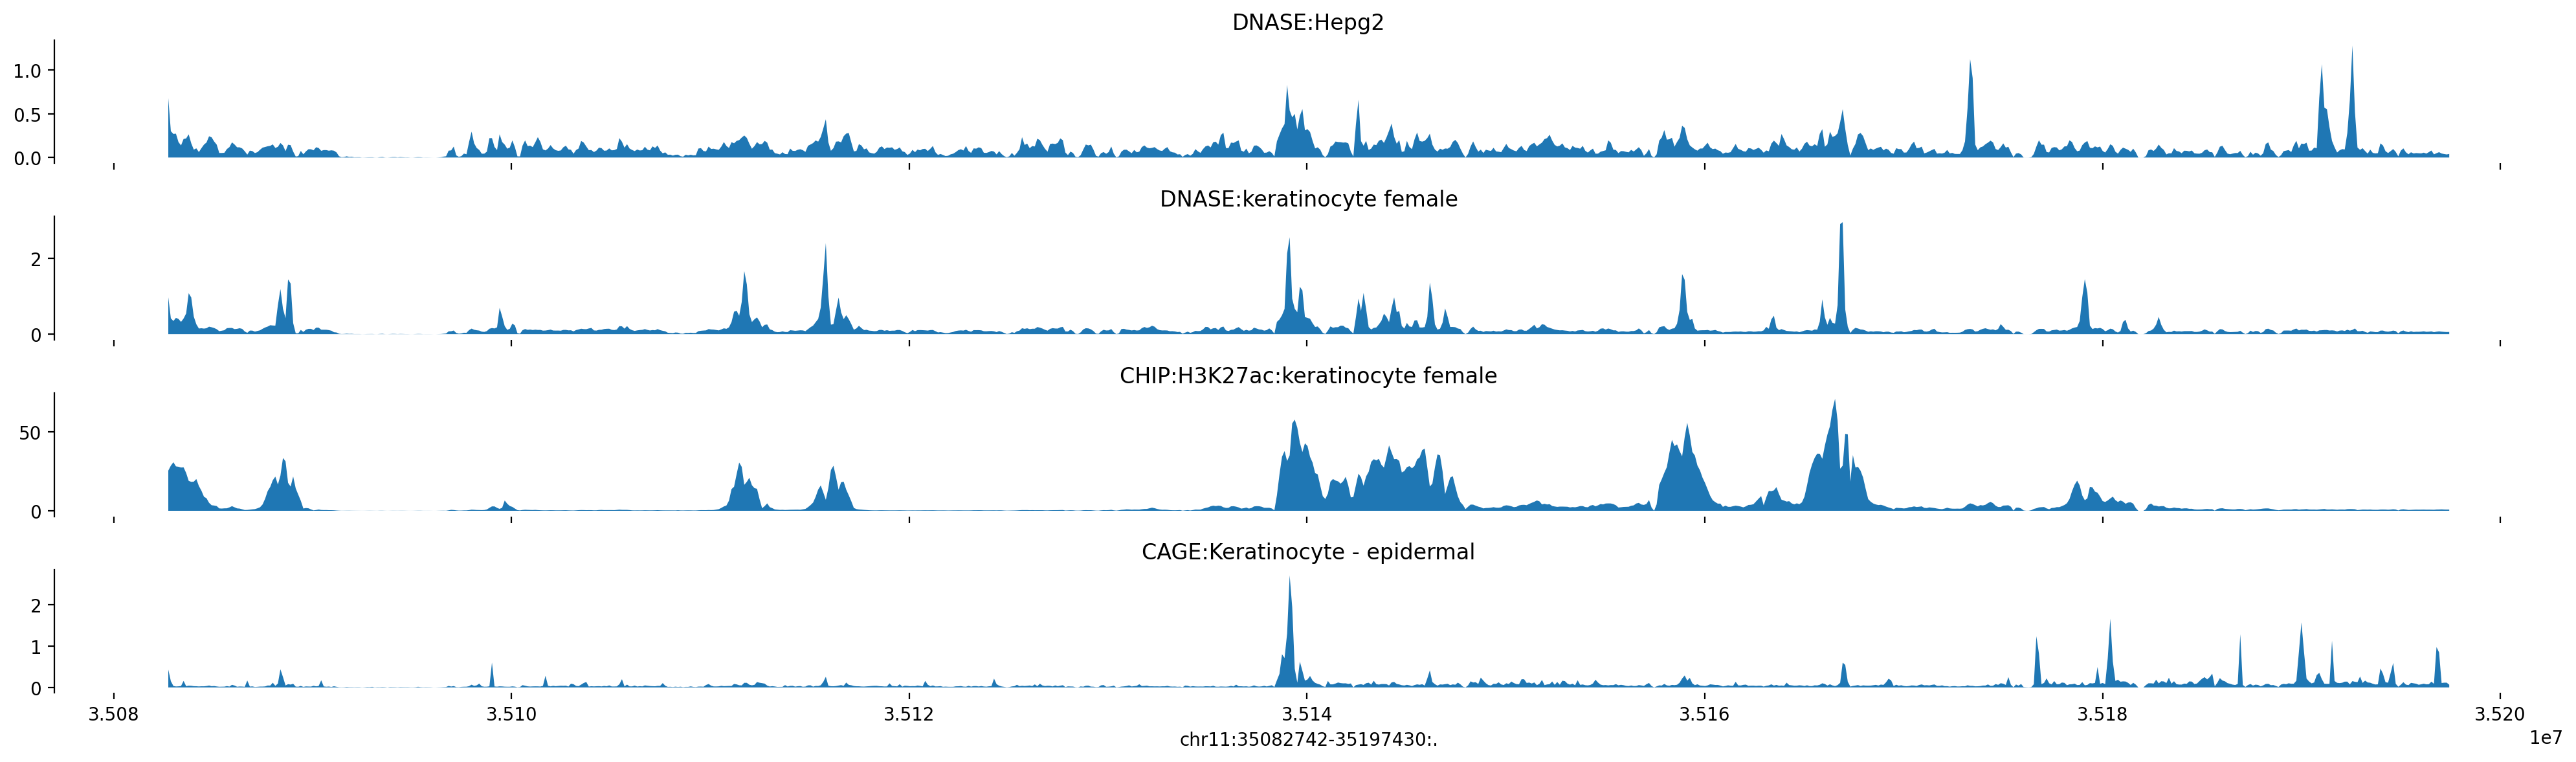

In [59]:
# @title Plot tracks
tracks = {'DNASE:Hepg2': predictions[:, 27],
          'DNASE:keratinocyte female': predictions[:, 42],
          'CHIP:H3K27ac:keratinocyte female': predictions[:, 706],
          'CAGE:Keratinocyte - epidermal': np.log10(1 + predictions[:, 4799])}
plot_tracks(tracks, target_interval)

## Contribution scores example

In [24]:
# @title Compute contribution scores
target_interval = kipoiseq.Interval('chr1', 100132791, 100133390)

sequence_one_hot = one_hot_encode(fasta_extractor.extract(target_interval.resize(SEQUENCE_LENGTH)))
predictions = model.predict_on_batch(sequence_one_hot[np.newaxis])['human'][0]

target_mask = np.zeros_like(predictions)
for idx in [446, 447, 448, 449, 450]:
  target_mask[idx, 27] = 1
  target_mask[idx, 91] = 1
  target_mask[idx, 234] = 1
# This will take some time since tf.function needs to get compiled.
contribution_scores = model.contribution_input_grad(sequence_one_hot.astype(np.float32), target_mask).numpy()
pooled_contribution_scores = tf.nn.avg_pool1d(np.abs(contribution_scores)[np.newaxis, :, np.newaxis], 128, 128, 'VALID')[0, :, 0].numpy()[1088:-1088]
print(contribution_scores[196308:196908])


[ 2.43864916e-02  3.53208125e-01  2.58358806e-01  1.50602162e-01
  9.74878594e-02 -1.27321295e-02 -2.59990603e-01 -3.56949151e-01
  9.17605683e-03 -2.03568459e-01  1.03039011e-01 -2.90854257e-02
 -7.46094063e-03 -1.26394242e-01  8.89131203e-02 -2.71038622e-01
  1.68615788e-01 -4.46575992e-02 -2.27715448e-01 -4.99376208e-02
 -2.88408041e-01 -2.94072360e-01 -1.73080787e-01 -2.06855223e-01
  2.10190982e-01  2.33901322e-01  7.12816596e-01  5.31857550e-01
  4.32238758e-01 -1.46546572e-01 -1.44009247e-01 -1.45731300e-01
 -1.09962612e-01  1.34270340e-01  2.50944555e-01  4.06522006e-01
  3.60591799e-01 -1.93588197e-01 -4.99196827e-01  2.51835585e-02
  2.24698603e-01  1.71066582e-01  2.80999988e-01 -1.46915898e-01
 -4.21715617e-01 -4.45796967e-01  5.93126863e-02 -1.86646491e-01
 -3.03462565e-01 -1.54593602e-01 -1.36907205e-01  6.76046908e-02
  2.12081909e-01  2.28502855e-01  1.54670656e-01 -9.98629443e-03
 -1.49457037e-01 -3.81550193e-02  1.15974292e-01  1.93338156e-01
  3.12369049e-01  5.15469

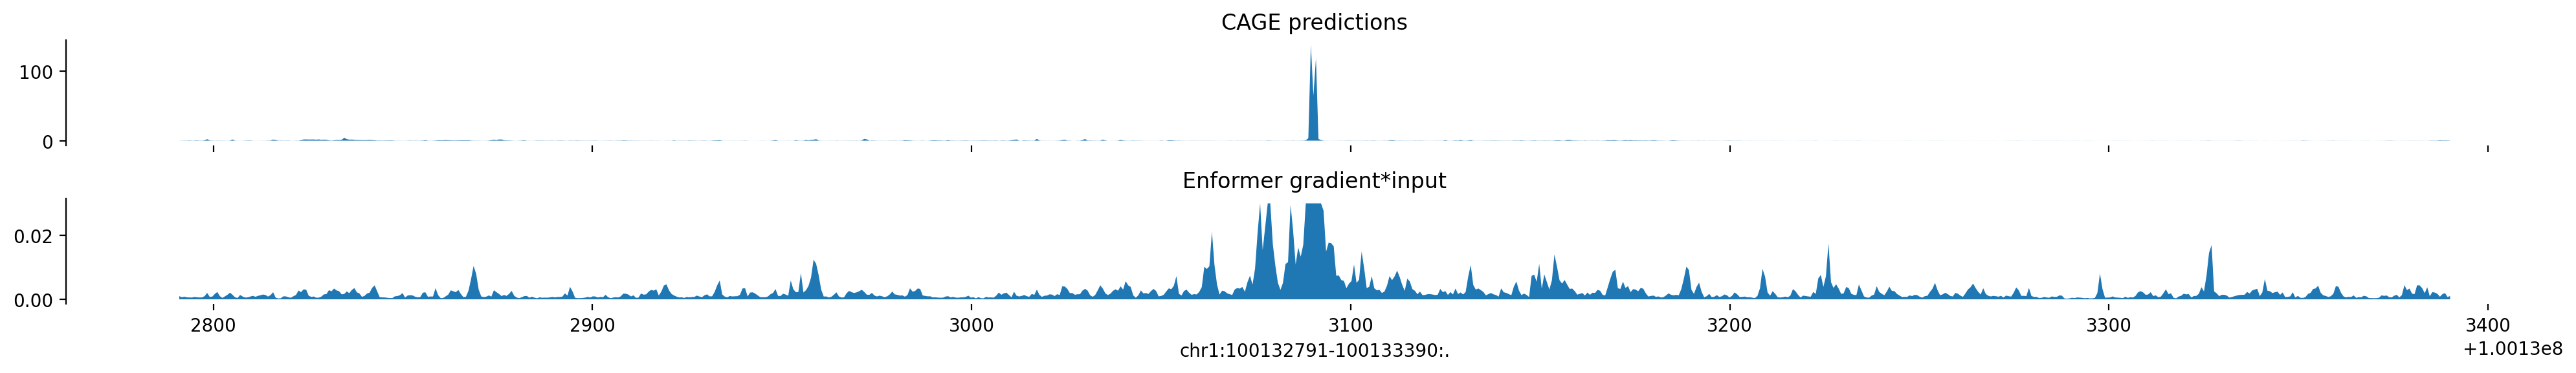

In [25]:
tracks = {'CAGE predictions': predictions[:, 4828],
          'Enformer gradient*input': np.minimum(pooled_contribution_scores, 0.03)}
plot_tracks(tracks, target_interval);

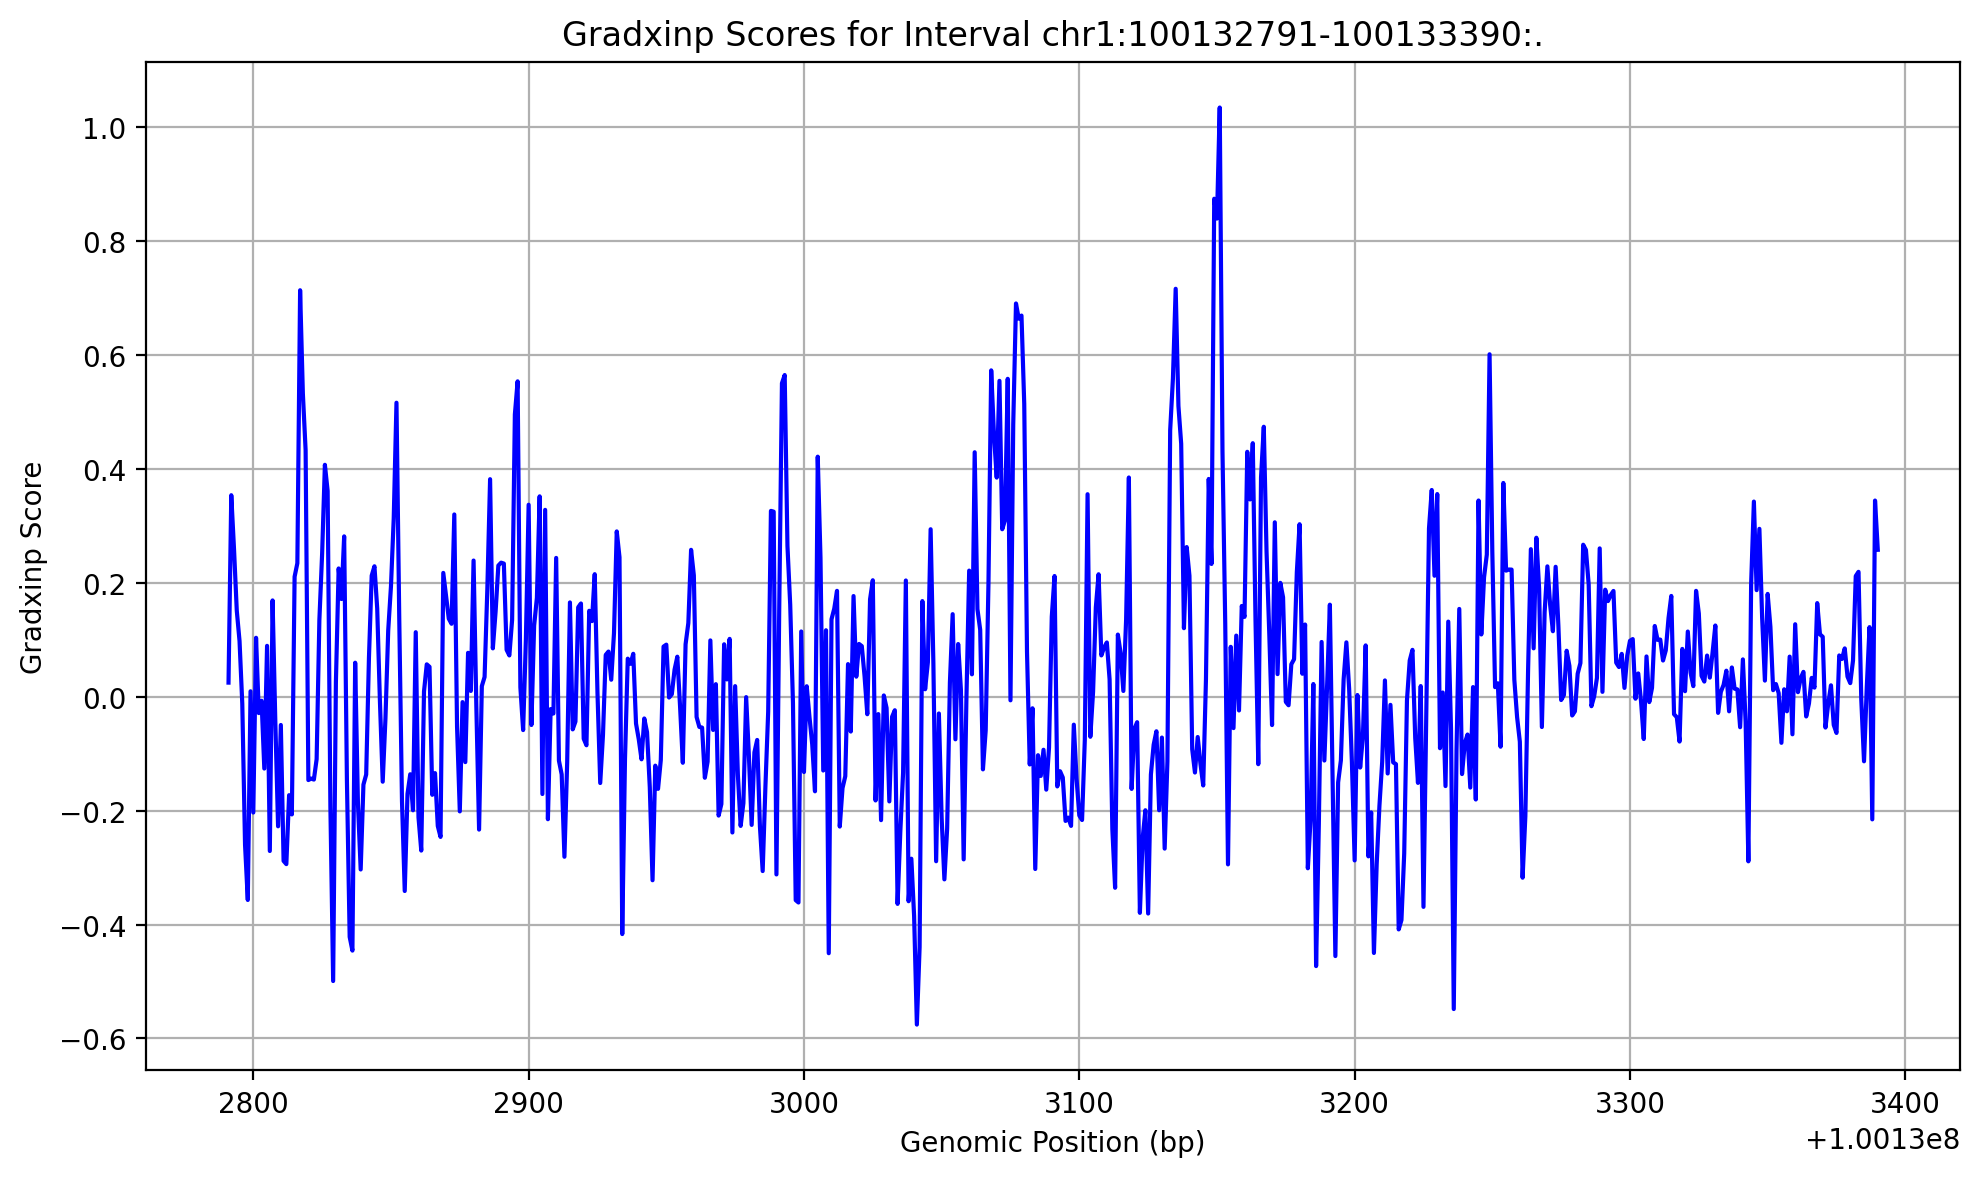

In [27]:
def plot_contribution_scores(target_interval, contribution_scores):

    start, end = target_interval.start, target_interval.end
    x_values = np.linspace(start, end, num=len(contribution_scores))


    plt.figure(figsize=(10, 6))
    plt.plot(x_values, contribution_scores, label="Gradxinp", color='blue')
    plt.title(f"Gradxinp Scores for Interval {target_interval}")
    plt.xlabel("Genomic Position (bp)")
    plt.ylabel("Gradxinp Score")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
plot_contribution_scores(target_interval, contribution_scores[196308:196908])

## Variant scoring example

In [21]:
# @title Score the variant
variant = kipoiseq.Variant('chr16', 57025062, 'C', 'G')

# Center the interval at the variant
interval = kipoiseq.Interval(variant.chrom, variant.start, variant.start).resize(SEQUENCE_LENGTH)
seq_extractor = kipoiseq.extractors.VariantSeqExtractor(reference_sequence=fasta_extractor)
center = interval.center() - interval.start

reference = seq_extractor.extract(interval, [], anchor=center)
alternate = seq_extractor.extract(interval, [variant], anchor=center)

# Make predictions for the refernece and alternate allele
reference_prediction = model.predict_on_batch(one_hot_encode(reference)[np.newaxis])['human'][0]
alternate_prediction = model.predict_on_batch(one_hot_encode(alternate)[np.newaxis])['human'][0]
print(alternate_prediction[448][27]-reference_prediction[448][27],
      alternate_prediction[448][91]-reference_prediction[448][91],
      alternate_prediction[448][234]-reference_prediction[448][234])


-0.05313137 -0.013161797 -0.0235748


In [ ]:
# ISM


In [29]:
# ISA
chr_name = 'chr6'
start_pos = 33183276
end_pos = 33183290

interval = kipoiseq.Interval(chr_name, start_pos, end_pos).resize(SEQUENCE_LENGTH)
seq_extractor = kipoiseq.extractors.VariantSeqExtractor(reference_sequence=fasta_extractor)


reference_sequence = seq_extractor.extract(interval, [], anchor=0)
# change every base to N
alternate_sequence = reference_sequence[:start_pos - interval.start] + 'N' * (end_pos - start_pos + 1) + reference_sequence[end_pos - interval.start + 1:]

reference_prediction = model.predict_on_batch(one_hot_encode(reference_sequence)[np.newaxis])['human'][0]
alternate_prediction = model.predict_on_batch(one_hot_encode(alternate_sequence)[np.newaxis])['human'][0]

print("Prediction difference at specific positions:")
print(alternate_prediction[448][27] - reference_prediction[448][27],
      alternate_prediction[448][91] - reference_prediction[448][91],
      alternate_prediction[448][234] - reference_prediction[448][234])


Prediction difference at specific positions:
-0.09188989 -0.0030949302 -0.045637563


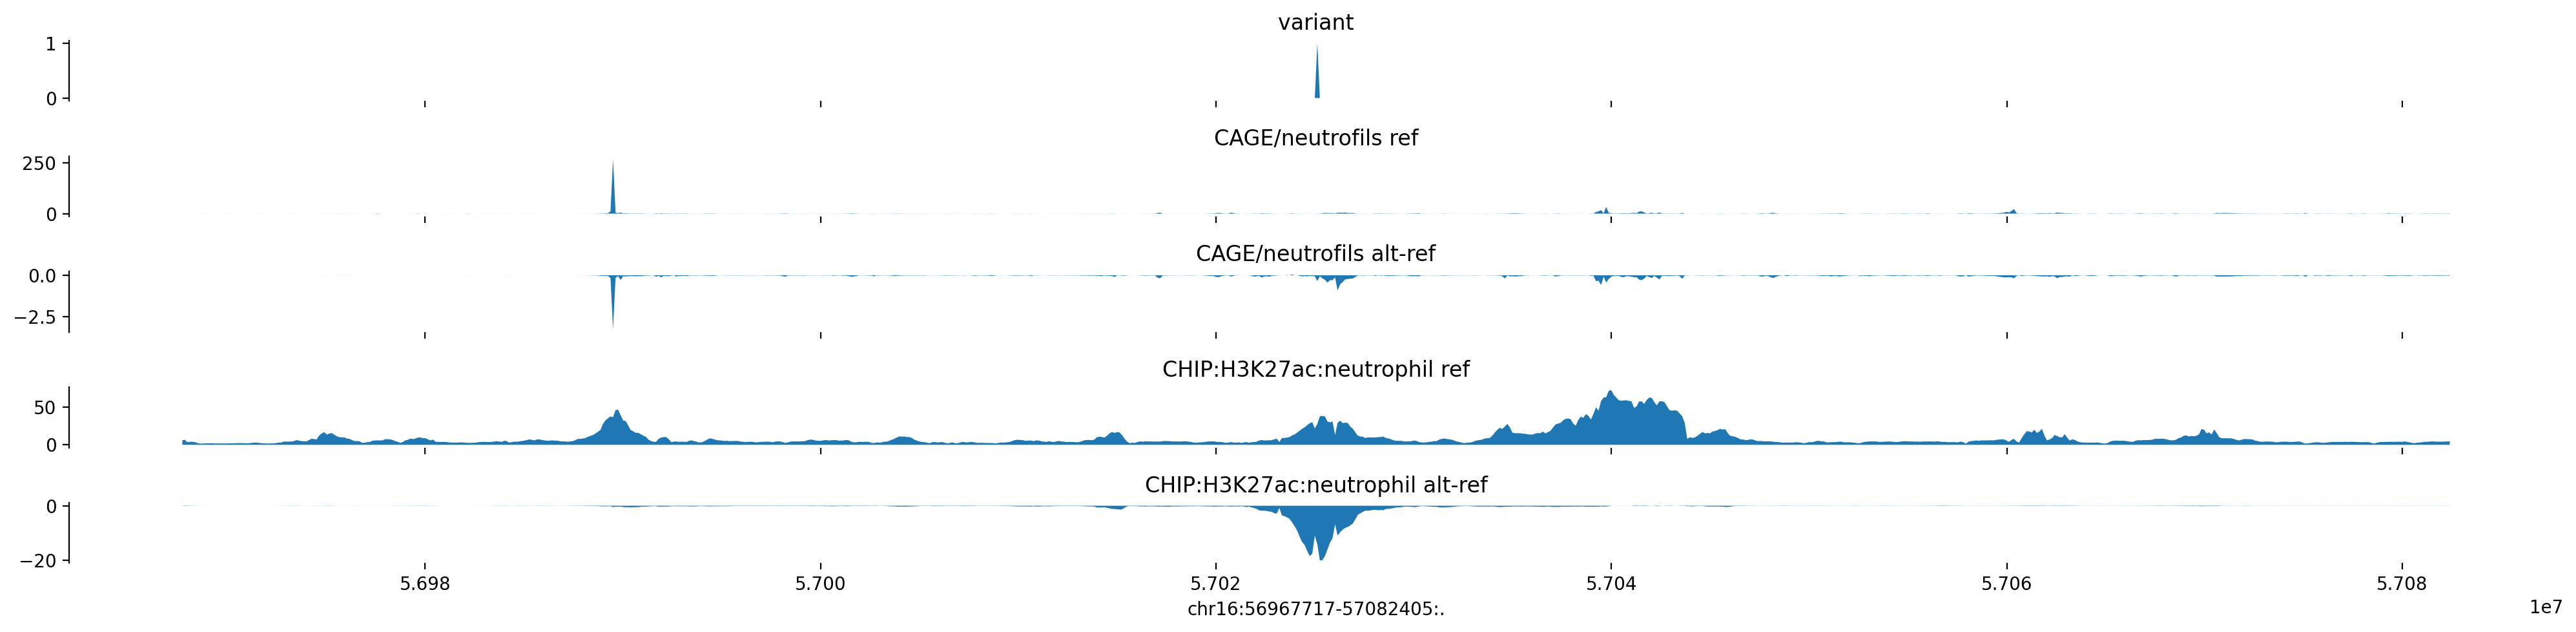

In [13]:
# @title Visualize some tracks
variant_track = np.zeros_like(reference_prediction[:, 0], dtype=bool)
variant_track[variant_track.shape[0] // 2] = True
tracks = {'variant': variant_track,
          'CAGE/neutrofils ref': reference_prediction[:, 4767],
          'CAGE/neutrofils alt-ref': alternate_prediction[:, 4767] - reference_prediction[:, 4767],
          'CHIP:H3K27ac:neutrophil ref': reference_prediction[:, 2280],
          'CHIP:H3K27ac:neutrophil alt-ref': alternate_prediction[:, 2280] - reference_prediction[:, 2280],
          }

plot_tracks(tracks, interval.resize(reference_prediction.shape[0] * 128), height=1)

## Score variants in a VCF file

### Report top 20 PCs

In [14]:
enformer_score_variants = EnformerScoreVariantsPCANormalized(model_path, transform_path, num_top_features=20)

NameError: name 'transform_path' is not defined

In [69]:
# Score the first 5 variants from ClinVar
# Lower-dimensional scores (20 PCs)
it = variant_centered_sequences(clinvar_vcf, sequence_length=SEQUENCE_LENGTH,
                                gzipped=True, chr_prefix='chr')
example_list = []
for i, example in enumerate(it):
  if i >= 5:
    break
  variant_scores = enformer_score_variants.predict_on_batch(
      {k: v[tf.newaxis] for k,v in example['inputs'].items()})[0]
  variant_scores = {f'PC{i}': score for i, score in enumerate(variant_scores)}
  example_list.append({**example['metadata'],
                       **variant_scores})
  if i % 2 == 0:
    print(f'Done {i}')
df = pd.DataFrame(example_list)
df

Done 0
Done 2
Done 4


,chrom,pos,id,ref,alt,PC0,PC1,PC2,PC3,PC4,...,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19
0,chr1,66926,3385321,AG,A,-836.315369,-115.440231,-105.900139,363.273560,3.018877,...,75.158844,31.477669,-195.514343,32.415237,-10.062559,206.206039,268.220001,74.072327,38.685390,-90.921181
1,chr1,69134,2205837,A,G,-7.433836,2.266492,-4.216559,7.759242,1.583094,...,1.202359,-0.871156,-5.367424,1.530206,-1.950563,4.246067,2.409740,-0.615580,-1.739353,0.807257
2,chr1,69314,3205580,T,G,-4.571053,7.087469,-8.081868,10.567356,2.177106,...,-1.293898,-0.043098,-11.757587,2.783792,-4.216281,3.039734,0.725118,-2.210103,-5.271435,1.839043
3,chr1,69423,3205581,G,A,-2.696733,-1.337527,0.443675,0.210968,-0.563631,...,0.410509,-0.328733,1.464794,-0.697998,0.839480,1.021723,1.527070,0.882408,1.409910,-0.935973
4,chr1,69581,2252161,C,G,-2.235742,4.260682,-6.350653,2.498435,-2.610382,...,-1.176314,1.512427,-2.997891,0.623062,-0.048547,1.531353,0.662046,-0.001673,-2.143237,0.973908


### Report all 5,313 features (z-score normalized)

In [70]:
enformer_score_variants_all = EnformerScoreVariantsNormalized(model_path, transform_path)

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RobustScaler from version 0.23.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator TruncatedSVD from version 0.23.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator Pipeline from version 0.23.2 when using version 1.6.1. This might lead to breaking code or invalid

In [71]:
# Score the first 5 variants from ClinVar
# All Scores
it = variant_centered_sequences(clinvar_vcf, sequence_length=SEQUENCE_LENGTH,
                                gzipped=True, chr_prefix='chr')
example_list = []
for i, example in enumerate(it):
  if i >= 5:
    break
  variant_scores = enformer_score_variants_all.predict_on_batch(
      {k: v[tf.newaxis] for k,v in example['inputs'].items()})[0]
  variant_scores = {f'{i}_{name[:20]}': score for i, (name, score) in enumerate(zip(df_targets.description, variant_scores))}
  example_list.append({**example['metadata'],
                       **variant_scores})
  if i % 2 == 0:
    print(f'Done {i}')
df = pd.DataFrame(example_list)
df

Done 0
Done 2
Done 4


,chrom,pos,id,ref,alt,0_DNASE:cerebellum mal,1_DNASE:frontal cortex,2_DNASE:chorion,3_DNASE:Ishikawa treat,4_DNASE:GM03348,...,"5303_CAGE:thalamus, adult","5304_CAGE:putamen, adult,",5305_CAGE:parietal cortex,5306_CAGE:medial temporal,5307_CAGE:squamous cell l,5308_CAGE:epithelioid sar,5309_CAGE:squamous cell l,5310_CAGE:gastric cancer,5311_CAGE:carcinoid cell,5312_CAGE:lung adenocarci
0,chr1,66926,3385321,AG,A,-108.822685,-163.584183,-174.875793,-122.801239,-199.401947,...,-76.828522,-91.283401,-96.373528,-47.146072,-689.539368,-605.781616,-910.920166,-393.344879,-494.432465,-798.717773
1,chr1,69134,2205837,A,G,-1.076869,-2.022007,-2.281388,-1.147865,-1.836769,...,-0.241208,-0.608879,-0.513116,0.370981,-3.685443,-5.994915,-7.966063,-3.198583,-2.547204,-4.590356
2,chr1,69314,3205580,T,G,-3.279533,-5.555248,-4.120863,-4.693124,-4.954987,...,-0.503883,-0.721776,-0.720765,0.085117,-4.814888,-1.793973,-3.119125,-2.725524,-3.960709,-4.879367
3,chr1,69423,3205581,G,A,-0.397194,-0.183287,-1.126625,0.551706,-0.265232,...,-0.296885,-0.407735,-0.356669,-0.235888,-1.961673,-1.145404,-1.635736,-0.771521,-1.890834,-1.798419
4,chr1,69581,2252161,C,G,0.322683,-0.098030,0.246014,0.129868,-0.321158,...,-4.024522,-3.091243,-3.106037,-3.172561,-5.723068,-1.507136,-5.036083,-5.338220,-3.692060,-6.553360
